In [1]:
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [2]:
json_df=pd.read_json("C:/Users/ASHRITHA/Downloads/1481053515_ultimate_challenge/ultimate_challenge/logins.json")
json_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
json_df.tail()

,login_time
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38
93141,1970-04-13 18:54:23


In [4]:
json_df.shape # number of entries


(93142, 1)

In [5]:
json_df.dtypes # datatype


login_time    datetime64[ns]
dtype: object

In [6]:
login_time = json_df['login_time']


In [7]:
# setting the index as date
json_df = json_df.set_index('login_time')
json_df.head()


""
login_time
1970-01-01 20:13:18
1970-01-01 20:16:10
1970-01-01 20:16:37
1970-01-01 20:16:36
1970-01-01 20:26:21


In [8]:
json_df.index


DatetimeIndex(['1970-01-01 20:13:18', '1970-01-01 20:16:10',
               '1970-01-01 20:16:37', '1970-01-01 20:16:36',
               '1970-01-01 20:26:21', '1970-01-01 20:21:41',
               '1970-01-01 20:12:16', '1970-01-01 20:35:47',
               '1970-01-01 20:35:38', '1970-01-01 20:47:52',
               ...
               '1970-04-13 18:36:53', '1970-04-13 18:40:31',
               '1970-04-13 18:46:06', '1970-04-13 18:40:40',
               '1970-04-13 18:48:52', '1970-04-13 18:50:19',
               '1970-04-13 18:43:56', '1970-04-13 18:54:02',
               '1970-04-13 18:57:38', '1970-04-13 18:54:23'],
              dtype='datetime64[ns]', name='login_time', length=93142, freq=None)

In [9]:
json_df['count'] = 1
json_df.sample(5, random_state=0)
#json_df


,count
login_time,
1970-03-13 21:11:44,1
1970-02-22 01:33:50,1
1970-01-25 03:16:20,1
1970-01-11 14:58:31,1
1970-03-19 02:42:31,1


In [10]:
count_sample = json_df[['count']]
type(count_sample)


pandas.core.frame.DataFrame

In [11]:
count_freq = count_sample.resample('15min').sum()


In [12]:
count_freq.head()


,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


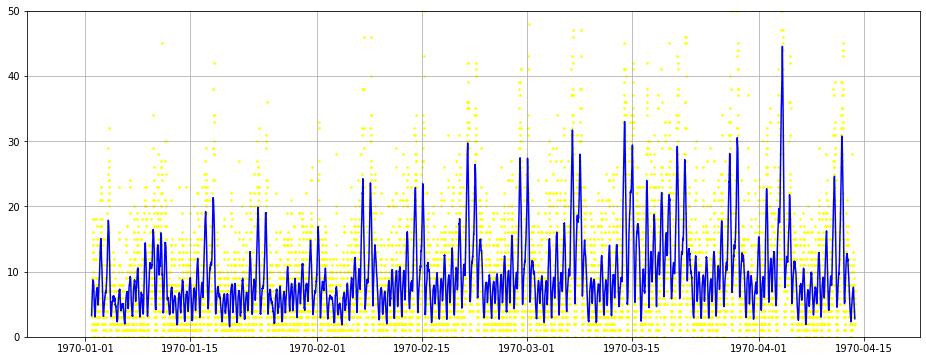

In [13]:
# time series of login frequency for the entire period
count_sample_plot = json_df['count']
count_freq_plot = count_sample_plot.resample('15min').sum()

# estimating moving average to smooth out the pattern
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window,'same')

x = count_freq_plot.index
y = count_freq_plot.values
y_av = movingaverage(y, 30)

# ploting actual login frequency and its moving average
plt.rcParams["figure.figsize"] = [16,6]
plt.scatter(x, y, s=10, marker='.', color='yellow')
plt.plot(x, y_av, color='blue')
plt.ylim(0, 50)
plt.grid()
plt.show()


In [14]:
count_freq['Year'] = count_freq.index.year
count_freq['Month'] = count_freq.index.month
count_freq['Day'] = count_freq.index.day
count_freq['Week'] = count_freq.index.weekday_name
count_freq['hr'] = count_freq.index.hour
count_freq.sample(5, random_state=0)
#count_freq.head()


,count,Year,Month,Day,Week,hr
login_time,,,,,,
1970-02-16 15:45:00,5,1970,2,16,Monday,15
1970-02-23 18:15:00,7,1970,2,23,Monday,18
1970-04-08 09:00:00,6,1970,4,8,Wednesday,9
1970-01-06 12:15:00,17,1970,1,6,Tuesday,12
1970-03-16 03:15:00,4,1970,3,16,Monday,3


In [15]:
type(json_df)


pandas.core.frame.DataFrame

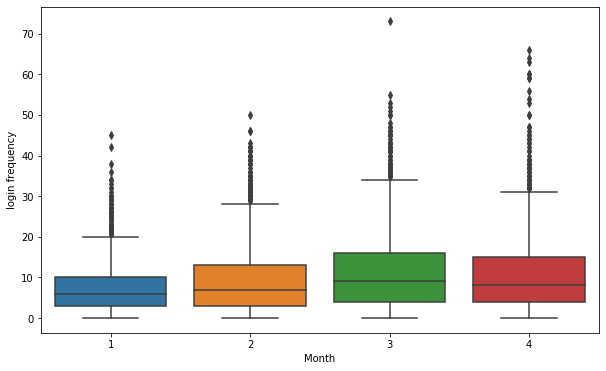

In [16]:
# Is there any month of year pattern?
plt.rcParams["figure.figsize"] = [10,6]
sns.boxplot(data=count_freq, x='Month', y='count')
plt.ylabel('login frequency')
plt.show()


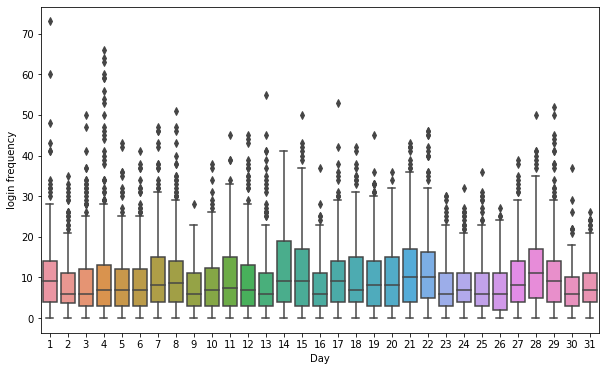

In [17]:
# Any pattern in day of month?
sns.boxplot(data=count_freq, x='Day', y='count')
plt.ylabel('login frequency')
plt.show()


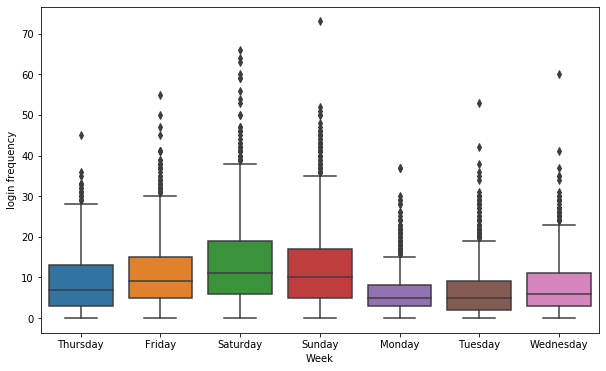

In [18]:
sns.boxplot(data=count_freq, x='Week', y='count')
plt.ylabel('login frequency')
plt.show()


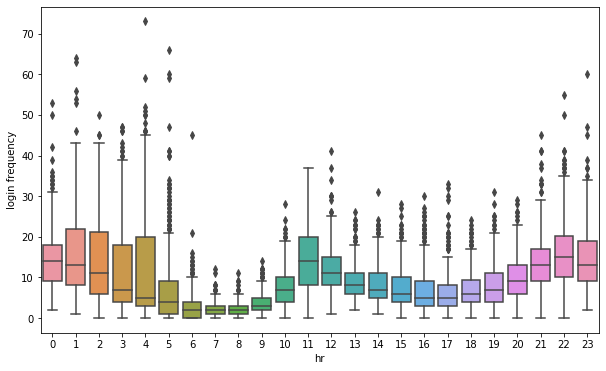

In [19]:
sns.boxplot(data=count_freq, x='hr', y='count')
plt.ylabel('login frequency')
plt.show()


This reveals the hourly activity throughout the day. Without the information of the login timezone, we clearly see two peaks and two troughs. The most idle time was from 6 to 9 am (people are probably getting ready for work or on the road). The activity peaks around 11 am.The second low is formed between 5pm to 6pm before it again rises.

Part 2: Experiment and metrics design
Information:

Gotham is mostly active at night.
Metropolis is mostly active at day.
The 2 way toll between the city tends to keep the drivers exclusive to the cities.
Change in the management: The toll would be reimbursed.
Assmption:

The driver partners are active 24 hrs
Because Gotham is not so active during the day, drivers do not drive there differently than it did before. So there is no change in that pattern during day. But at night drivers drive from motropolis through toll. Same is with metropolis. So the key measure of the success would be the difference between the number of cars passing the toll during day and night in each city.
Experiment and metrics design: Number of vehicle from Gotham to metropolis during day = n_G_day Number of vehicle from Gotham to metropolis at night = n_G_night The difference in number of vehicles going through the toll before and after the reimbursement is similar to difference between day and night: n_G_night - n_G_day

Number of vehicle from metropolis to Gotham at night = n_M_night Number of vehicle from metropolis to Gotham during day = n_M_day Total difference = n_M_night - n_M_day

We have to check whether the difference in number of cars is statistically significant. We will first assume that the difference is just by chance, which will be our null hypothesis. We will estimate the p-value. If it is less than 0.05, we will reject the null hypothesis that it was just random, meaning the difference was statistically significant and the experiment was successful.

Part 3: Predictive Modeling¶


In [22]:
#json_df1 = pd.read_json("ultimate_data_challenge.json", lines=True, orient='records')
file=open('C:/Users/ASHRITHA/Downloads/1481053515_ultimate_challenge/ultimate_challenge/ultimate_data_challenge.json', 'r')

file_content=file.read()

file.close()

data=json.loads(file_content)

df=pd.DataFrame(data)

In [23]:
df.head()


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [25]:
df.shape

(50000, 12)

In [26]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [27]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


A brief description of the dataset:

There are 12 features; among them 6 float type - avg_dist, avg_rating_by_driver, avg_rating_of_driver, avg_surge, surge_pct and weekday_pct; 4 categorical - city, last_trip_date, phone, signup_date, 1 integer type - trips_in_first_30_days, and 1 boolean type - ultimate_black_user. Among all the features avg_rating_by_driver, avg_rating_of_driver, and phone have missing values.



In [28]:
obj = df.select_dtypes('object') # selcting only categorical variable
obj_uni = obj.apply(pd.Series.nunique, axis=0) # unique values in category
print('\nUnique values in categorical variables are:\n', obj_uni.sort_values())



Unique values in categorical variables are:
 phone               2
city                3
signup_date        31
last_trip_date    182
dtype: int64


There are 4 categorical variables. Phone and city have 2 and 3 unique values, respectively. Signup_date and last_trip_date have 3 and 182 unique value respectively.



Variable 1: avg_dist¶


In [29]:
# data anomaly
df.avg_dist[df.avg_dist == 0.0].count()


150

A total of 150 entries have recorded average distance as 0, which doesn't make sense. We will replace them with median of average distance.



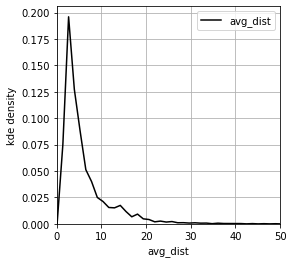

In [30]:
import seaborn as sns
plt.rcParams['figure.figsize'] = 4,4
sns.kdeplot(df.avg_dist, color='black')
plt.xlabel('avg_dist')
plt.ylabel('kde density')
plt.xlim(0, 50)
plt.grid(True)
plt.show()


Number of avg_dist as 0.0 is 0


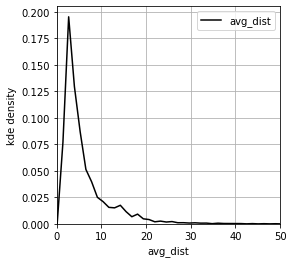

In [31]:
# Dealing with anomaly
df['avg_dist'] = df['avg_dist'].replace(0.0, df['avg_dist'].median()) # replacing 0.0 with median
print('Number of avg_dist as 0.0 is', df.avg_dist[df.avg_dist == 0.0].count())

# plot the distribution
plt.rcParams['figure.figsize'] = 4,4
sns.kdeplot(df.avg_dist, color='black')
plt.xlabel('avg_dist')
plt.ylabel('kde density')
plt.xlim(0, 50)
plt.grid(True)
plt.show()


Variable 2: avg_rating_by_driver


In [32]:
var = 'avg_rating_by_driver'
print('% missing value of', var, 'is:\n', df[var].isnull().sum()/len(df[var])* 100)


% missing value of avg_rating_by_driver is:
 0.402


avg_rating_by_driver has 0.4% missing values. We will replace them with median of avg_rating_by_driver.



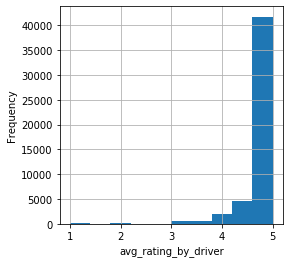

In [33]:
# Dealing with missing values
var = 'avg_rating_by_driver'
df[var] = df[var].fillna(df[var].median())

# 
plt.rcParams['figure.figsize'] = 4,4
#sns.kdeplot(df[var], color='black')
plt.hist(df[var], bins=10, histtype='bar')
plt.xlabel(var)
plt.ylabel('Frequency')
#plt.xlim(0, 50)
plt.grid(True)
plt.show()


The rating is pretty high in general.



Variable 3: avg_rating_of_driver¶


In [34]:
var = 'avg_rating_of_driver'
print('% missing value of', var, 'is:\n', df[var].isnull().sum()/len(df[var])* 100)


% missing value of avg_rating_of_driver is:
 16.244


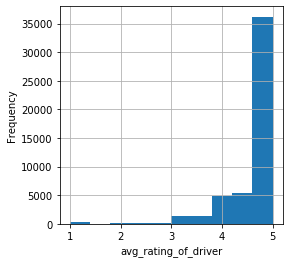

In [35]:
# Dealing with missing values
var = 'avg_rating_of_driver'
df[var] = df[var].fillna(df[var].median())

# plotting the distribution
plt.rcParams['figure.figsize'] = 4,4
plt.hist(df[var], bins=10, histtype='bar')
plt.xlabel(var)
plt.ylabel('Frequency')
#plt.xlim(0, 50)
plt.grid(True)
plt.show()


Variable 4: avg_surge¶


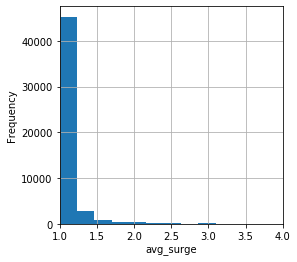

In [36]:
var = 'avg_surge'
# plotting the distribution
plt.rcParams['figure.figsize'] = 4,4
plt.hist(df[var], bins=30, histtype='bar')
plt.xlabel(var)
plt.ylabel('Frequency')
plt.xlim(1, 4)
#plt.yscale('log')
plt.grid(True)
plt.show()


Variable 5: city¶


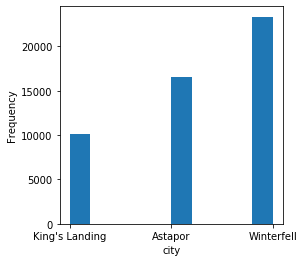

In [37]:
var = 'city'
plt.rcParams['figure.figsize'] = 4,4
plt.hist(df[var], histtype='bar')
plt.xlabel(var)
plt.ylabel('Frequency')
plt.show()


Variable 6: last_trip_date, 8: signup_date¶


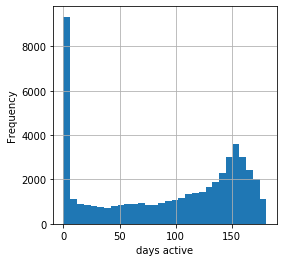

In [41]:
from datetime import timedelta
df.last_trip_date = pd.to_datetime(df['last_trip_date']) # changing to datetime
df.signup_date = pd.to_datetime(df['signup_date'])

# how many days are the users active after signup?
day_active = (df.last_trip_date - df.signup_date).dt.days
day_active[:10]

# plotting day_active 
plt.rcParams['figure.figsize'] = 4,4
plt.hist(day_active, bins=30, histtype='bar')
plt.xlabel('days active')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [39]:
df['day_active'] = pd.Series(day_active)


What fraction of the observed users were retained?¶


In [40]:
df.user_retain = (day_active>30)
df.user_retain[:5]


0     True
1     True
2    False
3     True
4     True
dtype: bool

A new variable 'user_retain' is created based on the values of day_active values. If the day_active is larger than 30, which in other word suggests the users took a trip 30 days after the signed up, they are considered as retained user. We will use user_retain as the target variable.



In [42]:
target = []
for i in range(len(df.user_retain)):
    if df.user_retain[i] == True:
        x = 1
    else:
        x = 0
    #print(x)
    target.append(x)

In [43]:
#df['Price'] = pd.Series(Price)
df['target'] = pd.Series(target)
df['target'][:5]


0    1
1    1
2    0
3    1
4    1
Name: target, dtype: int64

In [44]:
df['target'].sum()/len(df['target'])*100


73.946

73.95% users are retained after one month of signup.¶


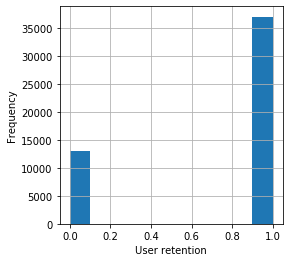

In [45]:
# plotting target variable
plt.rcParams['figure.figsize'] = 4,4
plt.hist(df.target, histtype='bar')
plt.xlabel('User retention')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [46]:
var = 'phone'
print('% missing value of', var, 'is:\n', df[var].isnull().sum()/len(df[var])* 100)


% missing value of phone is:
 0.792


phone 0.8% missing values. We will replace the missing values as 'missing'.



In [47]:
df[var] = df[var].fillna('missing')
print('% missing value of', var, 'is:\n', df[var].isnull().sum()/len(df[var])* 100)


% missing value of phone is:
 0.0


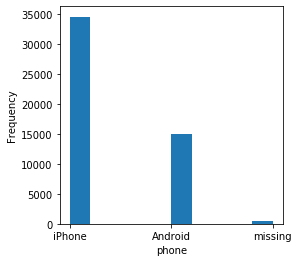

In [48]:
var = 'phone'
plt.rcParams['figure.figsize'] = 4,4
plt.hist(df[var], histtype='bar')
plt.xlabel(var)
plt.ylabel('Frequency')
plt.show()


The users have Android, or iPhone. A small fraction has 'missing' records.



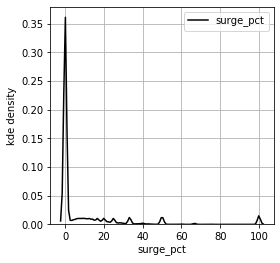

In [49]:
var = 'surge_pct'
plt.rcParams['figure.figsize'] = 4,4
sns.kdeplot(df[var], color='black')
plt.xlabel(var)
plt.ylabel('kde density')
#plt.xlim(0, 50)
plt.grid(True)
plt.show()


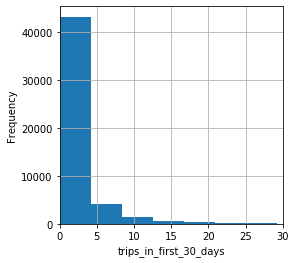

In [50]:
var = 'trips_in_first_30_days'
plt.rcParams['figure.figsize'] = 4,4
plt.hist(df[var], bins = 30, histtype='bar')
plt.xlim(0, 30)
plt.xlabel(var)
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [51]:
black_user = []
for i in range(len(df.ultimate_black_user)):
    if df.ultimate_black_user[i] == True:
        x = 1
    else:
        x = 0
    #print(x)
    black_user.append(x)


In [52]:
#df['Price'] = pd.Series(Price)
df['black_user'] = pd.Series(black_user)
df['black_user'][:5]


0    1
1    0
2    0
3    1
4    0
Name: black_user, dtype: int64

In [53]:
df.head()


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,day_active,target,black_user
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,143,1,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,96,1,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,1,0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,170,1,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,47,1,0


In [54]:
df.tail()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,day_active,target,black_user
49995,King's Landing,0,2014-01-25,5.0,1.0,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2,131,1,0
49996,Astapor,1,2014-01-24,4.9,1.0,2014-01-25,iPhone,0.0,False,0.0,3.88,4.0,1,0,0
49997,Winterfell,0,2014-01-31,5.0,1.0,2014-05-22,Android,0.0,True,100.0,3.86,5.0,111,1,1
49998,Astapor,2,2014-01-14,3.0,1.0,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5,1,0,0
49999,Astapor,0,2014-01-18,4.9,1.0,2014-04-20,Android,0.0,False,0.0,3.49,5.0,92,1,0


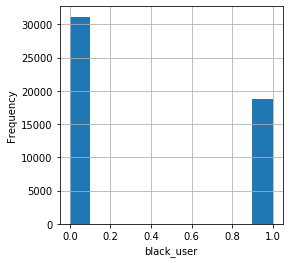

In [55]:
var = 'black_user'
plt.rcParams['figure.figsize'] = 4,4
plt.hist(df['black_user'], histtype='bar')
#plt.xlim(0, 30)
plt.xlabel(var)
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


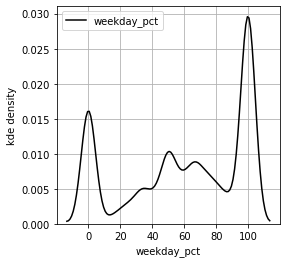

In [56]:
# weekday_pct
var = 'weekday_pct'
plt.rcParams['figure.figsize'] = 4,4
sns.kdeplot(df[var], color='black')
plt.xlabel(var)
plt.ylabel('kde density')
#plt.xlim(0, 50)
plt.grid(True)
plt.show()


In [57]:
columns = df.columns
columns[:]


Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'day_active', 'target', 'black_user'],
      dtype='object')

In [58]:
df = df.drop(columns = ['signup_date','last_trip_date', 'ultimate_black_user'])


In [59]:
df.head()


,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,day_active,target,black_user
0,King's Landing,4,4.7,1.10,iPhone,15.4,46.2,3.67,5.0,143,1,1
1,Astapor,0,5.0,1.00,Android,0.0,50.0,8.26,5.0,96,1,0
2,Astapor,3,4.3,1.00,iPhone,0.0,100.0,0.77,5.0,1,0,0
3,King's Landing,9,4.6,1.14,iPhone,20.0,80.0,2.36,4.9,170,1,1
4,Winterfell,14,4.4,1.19,Android,11.8,82.4,3.13,4.9,47,1,0


In [60]:
## One hot encoding for unique category >2
df_obj = pd.get_dummies(df.select_dtypes('object'))


In [61]:
df_obj.head()


,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,phone_missing
0,0,1,0,0,1,0
1,1,0,0,1,0,0
2,1,0,0,0,1,0
3,0,1,0,0,1,0
4,0,0,1,1,0,0


In [62]:
obj_columns = df_obj.columns

for col in obj_columns:
    df[col] = df_obj[col]


In [63]:
df = df.drop(columns = ['city', 'phone'])


In [64]:
df.head()


,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,day_active,target,black_user,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,phone_missing
0,4,4.7,1.10,15.4,46.2,3.67,5.0,143,1,1,0,1,0,0,1,0
1,0,5.0,1.00,0.0,50.0,8.26,5.0,96,1,0,1,0,0,1,0,0
2,3,4.3,1.00,0.0,100.0,0.77,5.0,1,0,0,1,0,0,0,1,0
3,9,4.6,1.14,20.0,80.0,2.36,4.9,170,1,1,0,1,0,0,1,0
4,14,4.4,1.19,11.8,82.4,3.13,4.9,47,1,0,0,0,1,1,0,0


In [65]:
df.shape


(50000, 16)

We started with 12 features. We engineered the target variable, dropped sign_up and last_trip, transformed categorical variable through one-hot-coding and ended up on 16 variabes.

Earlier we observed that 73.9% of the users could be retained after one month. But what about after 5 month? We could again use the historial day_active dat.We will assume that 5 month totals roughly 150 days

In [66]:
(day_active[day_active>150].count())/len(day_active)*100


24.396

Almost 24.4% of the user would be retained on the 6th month.



In [67]:
df['user_retain_long'] = (day_active>150)
df['user_retain_long'][:5]

0    False
1    False
2    False
3     True
4    False
Name: user_retain_long, dtype: bool

In [68]:
target_long = []
for i in range(len(df.user_retain_long)):
    if df.user_retain_long[i] == True:
        x = 1
    else:
        x = 0
    #print(x)
    target_long.append(x)


In [69]:
df['target_long'] = pd.Series(target_long)
df['target_long'][:5]


0    0
1    0
2    0
3    1
4    0
Name: target_long, dtype: int64

In [70]:
df = df.drop(columns = 'user_retain_long')


In [71]:
df.columns


Index(['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver',
       'day_active', 'target', 'black_user', 'city_Astapor',
       'city_King's Landing', 'city_Winterfell', 'phone_Android',
       'phone_iPhone', 'phone_missing', 'target_long'],
      dtype='object')

In [72]:
corr = df['target'].corr(df['target_long'])
corr


0.33718386679697243

Predictive modeling¶
We have to figure out if the user would remain active on the 6th month.



In [73]:
label = df['target_long']
df = df.drop(columns='target_long')


In [74]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
features = list(df.columns)
df = pd.DataFrame(df, columns = features)
scaler.fit(df)
df = scaler.transform(df)
print(df.shape)
df


(50000, 16)


array([[0.032     , 0.925     , 0.01428571, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.024     , 0.825     , 0.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.        , 1.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.016     , 0.5       , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.975     , 0.        , ..., 1.        , 0.        ,
        0.        ]])

In [75]:
type(df)


numpy.ndarray

In [76]:
df = pd.DataFrame(df, columns = features)
print(df.shape)


(50000, 16)


In [77]:
df.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,day_active,target,black_user,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,phone_missing
0,0.032,0.925,0.014286,0.154,0.462,0.022740,1.000,0.790055,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.000,1.000,0.000000,0.000,0.500,0.051258,1.000,0.530387,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.024,0.825,0.000000,0.000,1.000,0.004722,1.000,0.005525,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.072,0.900,0.020000,0.200,0.800,0.014601,0.975,0.939227,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.112,0.850,0.027143,0.118,0.824,0.019385,0.975,0.259669,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [78]:
df = df.drop(columns= 'day_active') # as we might not have this value in reality


Logistic Regression¶


In [79]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, label, test_size = 0.3, random_state=42)


In [80]:
# logistic regression
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(C = 0.0001)
log_reg.fit(X_train, y_train)

LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [81]:
log_reg_pred = log_reg.predict_proba(X_test)[:, 1]


In [82]:
from sklearn.metrics import roc_auc_score
valid_auc = roc_auc_score(y_test, log_reg_pred)
valid_auc


0.7023162337672182

In [83]:
from sklearn.metrics import confusion_matrix
print('Confusion matrix: \n', confusion_matrix(y_test, log_reg.predict(X_test)))


Confusion matrix: 
 [[11333     0]
 [ 3667     0]]


A simple logistic regression predicted all users would be retained.



In [84]:
# random forest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
X_train, X_valid, y_train, y_valid = train_test_split(df, label, test_size = 0.3, random_state=42)
rf = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
rf.fit(X_train, y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=50, verbose=1,
                       warm_start=False)

In [85]:
rf_valid = rf.predict_proba(X_valid)[:, 1]
valid_auc = roc_auc_score(y_valid, rf_valid)
valid_auc


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


0.8099295947306171

In [92]:
print('Confusion matrix: \n', confusion_matrix(y_test, rf.predict(X_test)))


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Confusion matrix: 
 [[9914 1419]
 [1979 1688]]
